# MODEL PRUNING

In [1]:
#!pip freeze > requirements.txt
#!pip install -r requirements.txt
#!pip install "urllib3<2" # Warning

from transformers import AutoTokenizer

#main_model = "google-bert/bert-base-uncased"
main_model = "textattack/bert-base-uncased-SST-2"

tokenizer = AutoTokenizer.from_pretrained(main_model) # We use the same tokenizer throughout all models. It becomes more important for distilliation

dataset_id="glue"
dataset_config="sst2"

from datasets import load_dataset

dataset = load_dataset(dataset_id,dataset_config)
#dataset = load_dataset("SetFit/sst2")
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [2]:
def process(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, max_length=512
        #examples["text"], truncation=True, max_length=512
    )
    return tokenized_inputs

tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label","labels")
tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42)

tokenized_datasets["test"].features

{'sentence': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Warning
import torch
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from huggingface_hub import HfFolder

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
#labels = ["negative", "positive"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

def load_external_model(model_id: str):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    return model

pruned_model = load_external_model(main_model)

In [4]:
#!pip install torch-pruning

from transformers import AutoTokenizer, BertModel, BertForSequenceClassification
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertPooler
import torch_pruning as tp

hf_inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
example_inputs = {'input_ids': hf_inputs['input_ids'], 'token_type_ids': hf_inputs['token_type_ids'], 'attention_mask': hf_inputs['attention_mask']}

imp = tp.importance.MagnitudeImportance(p=2, group_reduction="mean")
base_macs, base_params = tp.utils.count_ops_and_params(pruned_model, example_inputs)
num_heads = {}

# All heads should be pruned simultaneously, so we group channels by head.
for m in pruned_model.modules():
    if isinstance(m, BertSelfAttention):
        num_heads[m.query] = m.num_attention_heads
        num_heads[m.key] = m.num_attention_heads
        num_heads[m.value] = m.num_attention_heads

# https://github.com/VainF/Torch-Pruning/blob/master/torch_pruning/pruner/algorithms/metapruner.py
pruner = tp.pruner.MetaPruner(
    pruned_model, 
    example_inputs, 
    global_pruning=False, # If False, a uniform pruning ratio will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=1, # the number of iterations to achieve target pruning ratio
    pruning_ratio=0.5,
    num_heads=num_heads,
    prune_head_dims=False,
    prune_num_heads=True,
    head_pruning_ratio=0.5,
    output_transform=lambda out: out.logits.sum(),
    ignored_layers=[pruned_model.bert.pooler],
)

for g in pruner.step(interactive=True):
    #print(g)
    g.prune()

# Modify the attention head size and all head size after pruning
for m in pruned_model.modules():
    if isinstance(m, BertSelfAttention):
        #print("Num heads: %d, head size: %d =>"%(m.num_attention_heads, m.attention_head_size))
        m.num_attention_heads = pruner.num_heads[m.query]
        m.attention_head_size = m.query.out_features // m.num_attention_heads
        m.all_head_size = m.query.out_features
        #print("Num heads: %d, head size: %d"%(m.num_attention_heads, m.attention_head_size))
        #print()
        
for m in pruned_model.modules():
    if isinstance(m, BertPooler):
        m.dense = torch.nn.Linear(384, 384)  # Modify the pooler layer to use 384 input/output features
        print(f"Modified pooler dense layer to in_features=384, out_features=384")

for m in pruned_model.modules():
    if isinstance(m, BertForSequenceClassification):
        m.classifier = torch.nn.Linear(384, 2)  # Modify classifier to match the new pooler output size
        print(f"Modified classifier output to {m.classifier.out_features}")

#print(pruned_model)

test_output = pruned_model(**example_inputs)
pruned_macs, pruned_params = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print("Base MACs: %f M, Pruned MACs: %f M"%(base_macs/1e6, pruned_macs/1e6))
print("Base Params: %f M, Pruned Params: %f M"%(base_params/1e6, pruned_params/1e6))

# Calculate the difference in parameters before and after pruning
params_diff = base_params - pruned_params

# Print the comparison
print("Difference in Params: %f M"%(params_diff/1e6))



Warning! No positional inputs found for a module, assuming batch size is 1.
Modified pooler dense layer to in_features=384, out_features=384
Modified classifier output to 2
Warning! No positional inputs found for a module, assuming batch size is 1.
Base MACs: 680.459522 M, Pruned MACs: 170.212994 M
Base Params: 109.483778 M, Pruned Params: 33.360770 M
Difference in Params: 76.123008 M


# Prune Basic Training example

In [5]:
# Evalutation METRICS
#%pip install evaluate
#%pip install scikit-learn
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification, EarlyStoppingCallback
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertPooler
import torch_pruning as tp
from evaluate import load
import numpy as np
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the accuracy metric
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

all_metrics = []

def compute_metrics(eval_pred):
    global all_metrics

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    #return {
    #    "accuracy": acc,#["accuracy"],
    #    "precision": precision,#["precision"],
    #    "recall": recall,#["recall"],
    #    "f1": f1,#["f1"]
    #}
    # Save the metrics in the global list (add a dictionary with metrics)
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    # Append the metrics to the list
    all_metrics.append(metrics)
    return metrics

#%pip show torch

training_args = TrainingArguments(
    output_dir="bla",
    num_train_epochs=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    fp16=False,
    learning_rate=3e-5,
    seed=33,
    # logging & evaluation strategies
    logging_dir=f"bla/logs",
    logging_strategy="epoch", # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    #metric_for_best_model="eval_loss",  # Monitor validation loss
    #greater_is_better=False, # For validation loss, less is better
    greater_is_better=True,
    #weight_decay=0.5
)

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

prune_trainer = Trainer (
    pruned_model,
    training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(1000)),
    eval_dataset=tokenized_datasets["validation"],
    #train_dataset=tokenized_datasets["validation"].shuffle(seed=42),
    #eval_dataset=tokenized_datasets["train"],#.shuffle(seed=42).select(range(1000)),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

/Users/christophknaden/venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_3595/996599779.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  prune_trainer = Trainer (


In [6]:
prune_trainer.train()

# Save metrics
all_metrics_pruned = all_metrics

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685900,0.695560,0.509174,0.254587,0.500000,0.337386
2,0.679900,0.694906,0.509174,0.254587,0.500000,0.337386


## Visulize Training

In [7]:
import matplotlib.pyplot as plt

def plot_train_eval_metrics(trainer, all_metrics):    
    # Get the training and validation losses
    train_losses = trainer.state.log_history

    # Extracting training and validation loss
    train_loss_values = [log['loss'] for log in train_losses if 'loss' in log]
    eval_loss_values = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create two subplots side by side

    # Plot the loss on the first axis (Train and Validation Loss)
    axes[0].plot(train_loss_values, label='Train Loss', color='tab:blue')
    axes[0].plot(eval_loss_values, label='Validation Loss', color='tab:orange')

    # Mark the best epoch for train and validation losses (minimum loss)
    best_train_epoch = train_loss_values.index(min(train_loss_values))
    best_eval_epoch = eval_loss_values.index(min(eval_loss_values))

    # Mark the best epochs with points
    axes[0].scatter(best_train_epoch, train_loss_values[best_train_epoch], color='tab:blue', zorder=5)
    axes[0].scatter(best_eval_epoch, eval_loss_values[best_eval_epoch], color='tab:orange', zorder=5)

    axes[0].set_title('Train and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Define the plotting function for all metrics on one graph (with best epoch marked)
    def plot_all_metrics_on_one_graph(all_metrics, ax):
        # Extract each metric from the all_metrics list
        accuracy = [metrics["accuracy"] for metrics in all_metrics]
        precision = [metrics["precision"] for metrics in all_metrics]
        recall = [metrics["recall"] for metrics in all_metrics]
        f1 = [metrics["f1"] for metrics in all_metrics]

        # Plot all metrics on the same axis without points (just lines)
        ax.plot(accuracy, label='Accuracy', color='tab:blue')
        ax.plot(precision, label='Precision', color='tab:green')
        ax.plot(recall, label='Recall', color='tab:red')
        ax.plot(f1, label='F1 Score', color='tab:purple')

        # Mark the best epoch for each metric with a point (max value)
        best_accuracy_epoch = accuracy.index(max(accuracy))
        best_precision_epoch = precision.index(max(precision))
        best_recall_epoch = recall.index(max(recall))
        best_f1_epoch = f1.index(max(f1))

        # Mark the best epochs with points
        ax.scatter(best_accuracy_epoch, accuracy[best_accuracy_epoch], color='tab:blue', zorder=5)
        ax.scatter(best_precision_epoch, precision[best_precision_epoch], color='tab:green', zorder=5)
        ax.scatter(best_recall_epoch, recall[best_recall_epoch], color='tab:red', zorder=5)
        ax.scatter(best_f1_epoch, f1[best_f1_epoch], color='tab:purple', zorder=5)

        # Add title and labels
        ax.set_title('Evaluation Metrics Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Metric Value')

        # Show legend
        ax.legend()

    # Create the second plot for all metrics with best epochs marked
    plot_all_metrics_on_one_graph(all_metrics, axes[1])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

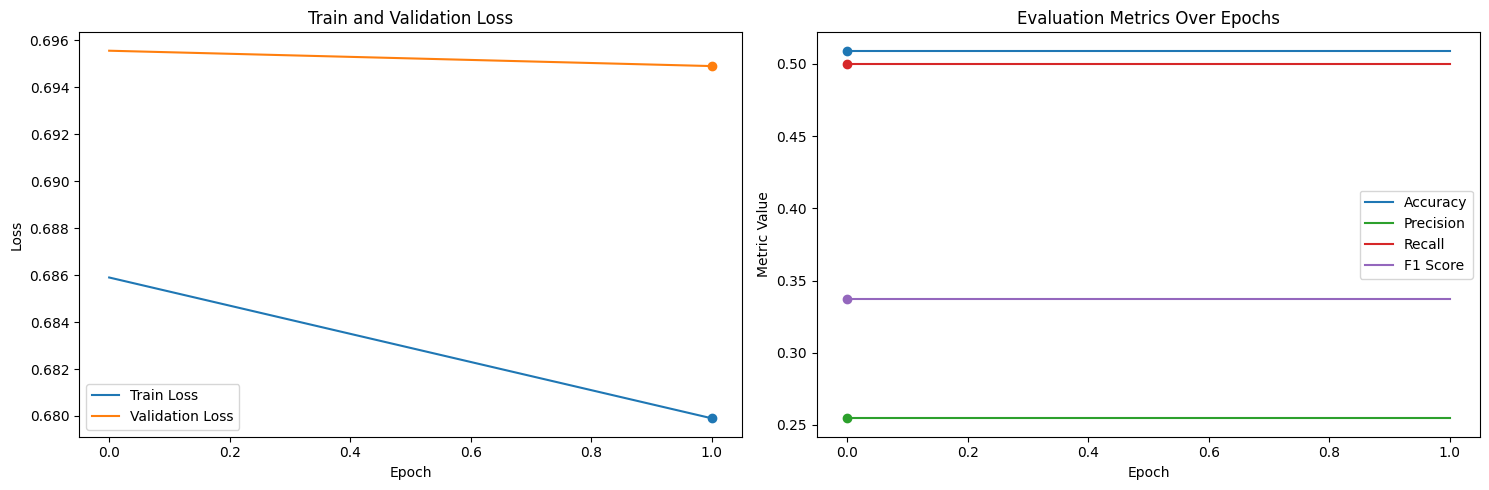

In [8]:
plot_train_eval_metrics(prune_trainer, all_metrics_pruned)

In [9]:
# Pruned model path with training
pruned_model_trained_path = "./pruned_model_trained"

In [10]:
# Save pruned model with training
prune_trainer.save_model(pruned_model_trained_path)

In [11]:
from transformers import BertConfig
def load_local_model(model_path: str, set_size=False):
    # Load the configuration for the model
    model_config = BertConfig.from_pretrained(f"{model_path}/config.json")

    if set_size == True:
        model_config.hidden_size = 384
        model_config.intermediate_size = 1536
        
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        config=model_config,
        local_files_only=True,
        ignore_mismatched_sizes=True,
        )
    
    return model

In [12]:
pruned_model_trained = load_local_model(pruned_model_trained_path, set_size=True)

pruned_model_trained_for_distillation = pruned_model_trained # avoid overriding during distillation training

# START KNOWLEDGE DISTILLATION

## Installation

In [ ]:
#%pip install "pytorch==1.10.1"
#%pip install transformers datasets tensorboard --upgrade
#!sudo apt-get install git-lfs
#!brew install git-lfs

In [ ]:
from huggingface_hub import login

login()  # displays a widget in a notebook, a prompt in terminal otherwise
#

In [13]:
tiny_bert_id = "google/bert_uncased_L-2_H-128_A-2"
teacher_id = main_model # We use the same model as in the beginingx

# name for our repository on the hub
repo_name = "tiny-bert-sst2-distilled_combined"

In [14]:
%%writefile custom_args.py
# Write class to external class to work
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

Overwriting custom_args.py


In [15]:
#%pip install torch torchvision torchaudio
import importlib
import custom_args
importlib.reload(custom_args)
from custom_args import DistillationTrainingArguments
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

#class DistillationTrainingArguments(TrainingArguments):
#    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
#        super().__init__(*args, **kwargs)
#
#        self.alpha = alpha
#        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, accelerator=None, **kwargs): #def __init__(self, *args, teacher_model=None, accelerator=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model

        self.accelerator = accelerator if accelerator else Accelerator()
        # Place teacher model on the correct device using the accelerator
        self.teacher = self.accelerator.prepare(self.teacher)
        
        # place teacher on same device as student
        #self._move_model_to_device(self.teacher,self.model.device)
        self.teacher.eval()

def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    # compute student output
    outputs_student = model(**inputs)
    student_loss = outputs_student.loss

    # compute teacher output
    with torch.no_grad():
        outputs_teacher = self.teacher(**inputs)

    # assert size
    assert outputs_student.logits.size() == outputs_teacher.logits.size()

    # Soften probabilities and compute distillation loss
    loss_function = nn.KLDivLoss(reduction="batchmean")
    loss_logits = (loss_function(
        F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
        F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

    # Return weighted student loss
    loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
    return (loss, outputs_student) if return_outputs else loss


### Hyperparameter Definition, Model Loading

In [16]:
#%pip install transformers[torch]
#%pip install "accelerate==1.2.1"

from transformers import DataCollatorWithPadding
from huggingface_hub import HfFolder

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# define training args
training_args = DistillationTrainingArguments(
    output_dir=repo_name,
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    fp16=False,
    learning_rate=3e-5,
    seed=33,
    # logging & evaluation strategies
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch", # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    metric_for_best_model="eval_loss",  # Monitor validation loss
    greater_is_better=False, # For validation loss, less is better
    report_to="tensorboard",
    # push to hub parameters
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name,
    hub_token=HfFolder.get_token(),
    # distilation parameters
    alpha=0.5,
    temperature=4.0
    )

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

teacher_model = load_external_model(teacher_id)

# define student model
#student_model = AutoModelForSequenceClassification.from_pretrained(
#    student_id,
#    num_labels=num_labels,
#    id2label=id2label,
#    label2id=label2id,
#)

/Users/christophknaden/venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training

Start training with calling `trainer.train`

In [17]:
from accelerate import Accelerator
accelerator = Accelerator(cpu=True)

start training using the `DistillationTrainer`.

In [18]:
# train pruned_model_trained with distillation
all_metrics = []
distilliation_trainer_pruned_trained = DistillationTrainer(
    pruned_model_trained_for_distillation,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"].select(range(1000)),
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator,
    callbacks=[early_stopping]
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_3595/304240063.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [19]:
distilliation_trainer_pruned_trained.train()

# save metrics
all_metrics_pruned_trained_distilled = all_metrics

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682600,0.694656,0.473624,0.461707,0.479951,0.406631
2,0.680300,0.689572,0.509174,0.254587,0.500000,0.337386
3,0.677900,0.684802,0.509174,0.254587,0.500000,0.337386
4,0.651800,0.677981,0.549312,0.565619,0.553307,0.529020
5,0.646900,0.653661,0.611239,0.620109,0.613444,0.606569
6,0.612900,0.627551,0.673165,0.673593,0.673497,0.673154
7,0.567900,0.598408,0.697248,0.698984,0.696220,0.695808
8,0.538000,0.600145,0.675459,0.687818,0.672929,0.667965
9,0.502300,0.578001,0.714450,0.715099,0.713785,0.713753
10,0.498200,0.575422,0.713303,0.713444,0.712869,0.712916


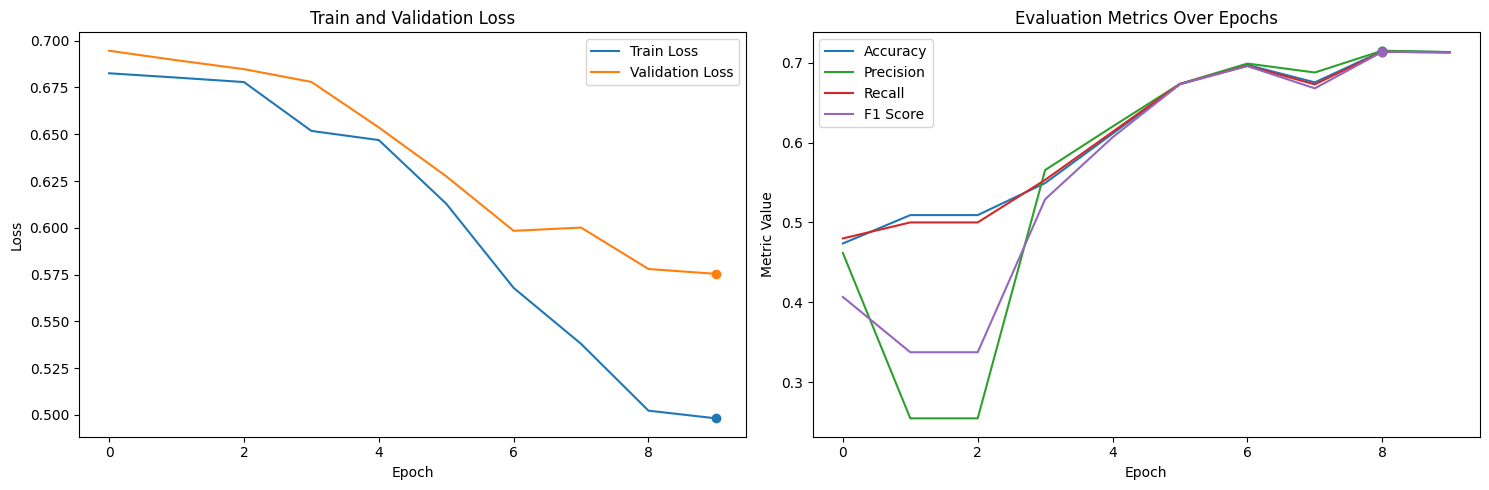

In [20]:
plot_train_eval_metrics(distilliation_trainer_pruned_trained, all_metrics_pruned_trained_distilled)

In [21]:
# Pruned model path with training
pruned_distilled_model_trained_path = "./pruned_distilled_model_trained"

In [22]:
# Save pruned model with training
distilliation_trainer_pruned_trained.save_model(pruned_distilled_model_trained_path)

In [23]:
pruned_distilled_model_trained = load_local_model(pruned_distilled_model_trained_path)

In [24]:
# train tiny_bert model with distillation
all_metrics = []

tiny_bert_model = load_external_model(tiny_bert_id)

distilliation_trainer_tiny_bert = DistillationTrainer(
    tiny_bert_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"].select(range(1000)),
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator,
    callbacks=[early_stopping]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_3595/304240063.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [25]:
distilliation_trainer_tiny_bert.train()

all_metrics_tiny_bert_distilled = all_metrics

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.681400,0.688660,0.513761,0.755760,0.504673,0.347674
2,0.676500,0.686793,0.513761,0.755760,0.504673,0.347674
3,0.675200,0.685319,0.513761,0.755760,0.504673,0.347674
4,0.671000,0.683222,0.526376,0.706454,0.517608,0.378818
5,0.670100,0.681694,0.534404,0.694616,0.525869,0.398915
6,0.670900,0.680037,0.543578,0.684343,0.535341,0.421943
7,0.669700,0.678705,0.549312,0.663988,0.541393,0.440185
8,0.665800,0.677639,0.549312,0.642690,0.541604,0.447050
9,0.663600,0.676958,0.555046,0.652679,0.547445,0.457346
10,0.664600,0.676726,0.556193,0.654546,0.548613,0.459386


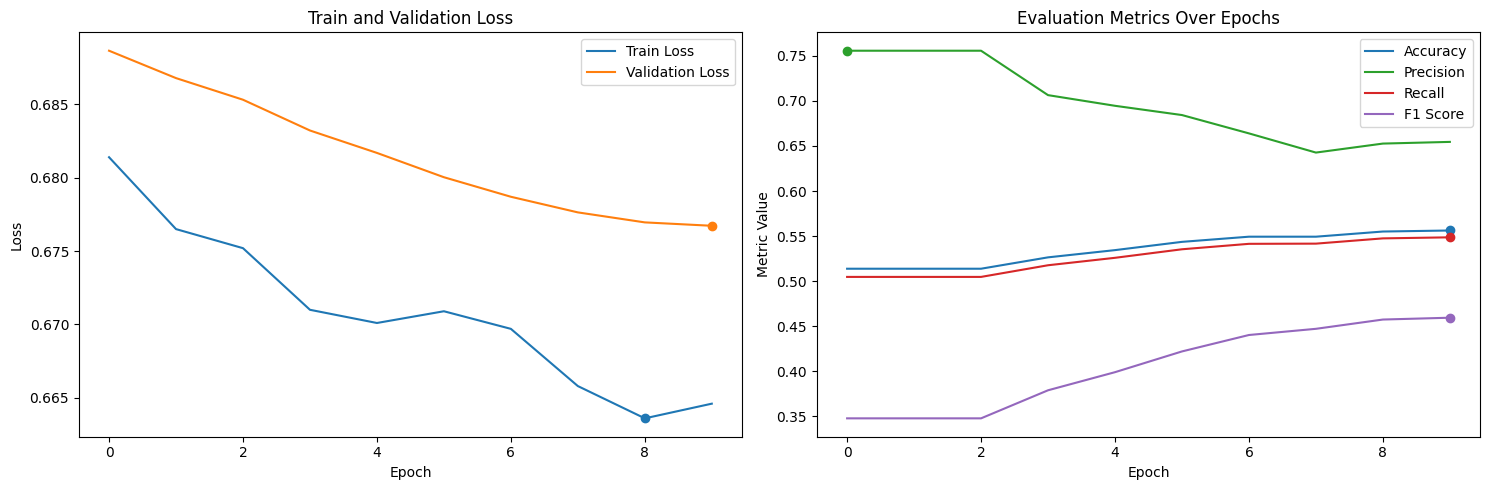

In [26]:
plot_train_eval_metrics(distilliation_trainer_tiny_bert, all_metrics_tiny_bert_distilled)

In [27]:
# Pruned model path with training
tiny_bert_distilled_model_path = "./tiny_bert_distilled_model"

In [28]:
# Save pruned model with training
distilliation_trainer_tiny_bert.save_model(tiny_bert_distilled_model_path)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

events.out.tfevents.1735084937.AirvonChristoph.fritz.box.3595.2:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

In [29]:
tiny_bert_distilled_model = load_local_model(tiny_bert_distilled_model_path)

In [30]:
#!pip install evaluate

from evaluate import evaluator
from transformers import pipeline

task_evaluator = evaluator("text-classification")

def evaluate_model(model, tokenizer, data):
    model_eval = task_evaluator.compute(
        model_or_pipeline=model,
        tokenizer=tokenizer,
        data=data,
        input_column="sentence",
        label_column="label",
        label_mapping={"negative": 0, "positive": 1}
    )

    return model_eval

In [31]:
val_data = load_dataset("glue","sst2", split="validation")

# Run all models on cpu for comparability
pruned_model_trained = pruned_model_trained.to("cpu")
pruned_distilled_model_trained = pruned_distilled_model_trained.to("cpu")
tiny_bert_model = tiny_bert_model.to("cpu")
tiny_bert_distilled_model = tiny_bert_distilled_model.to("cpu")
teacher_model = teacher_model.to("cpu")

pruned_model_eval = evaluate_model(pruned_model_trained, tokenizer, val_data)
pruned_distilled_model_eval = evaluate_model(pruned_distilled_model_trained, tokenizer, val_data)

tiny_bert_model.config.id2label = {0: 'negative', 1: 'positive'}
tiny_bert_model.config.label2id = {'negative': 0, 'positive': 1}
tiny_bert_model_eval = evaluate_model(tiny_bert_model, tokenizer, val_data)
tiny_bert_distilled_model_eval = evaluate_model(tiny_bert_distilled_model, tokenizer, val_data)

teacher_model.config.id2label = {0: 'negative', 1: 'positive'}
teacher_model.config.label2id = {'negative': 0, 'positive': 1}
teacher_model_eval = evaluate_model(teacher_model, tokenizer, val_data)

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


# Visualize Results

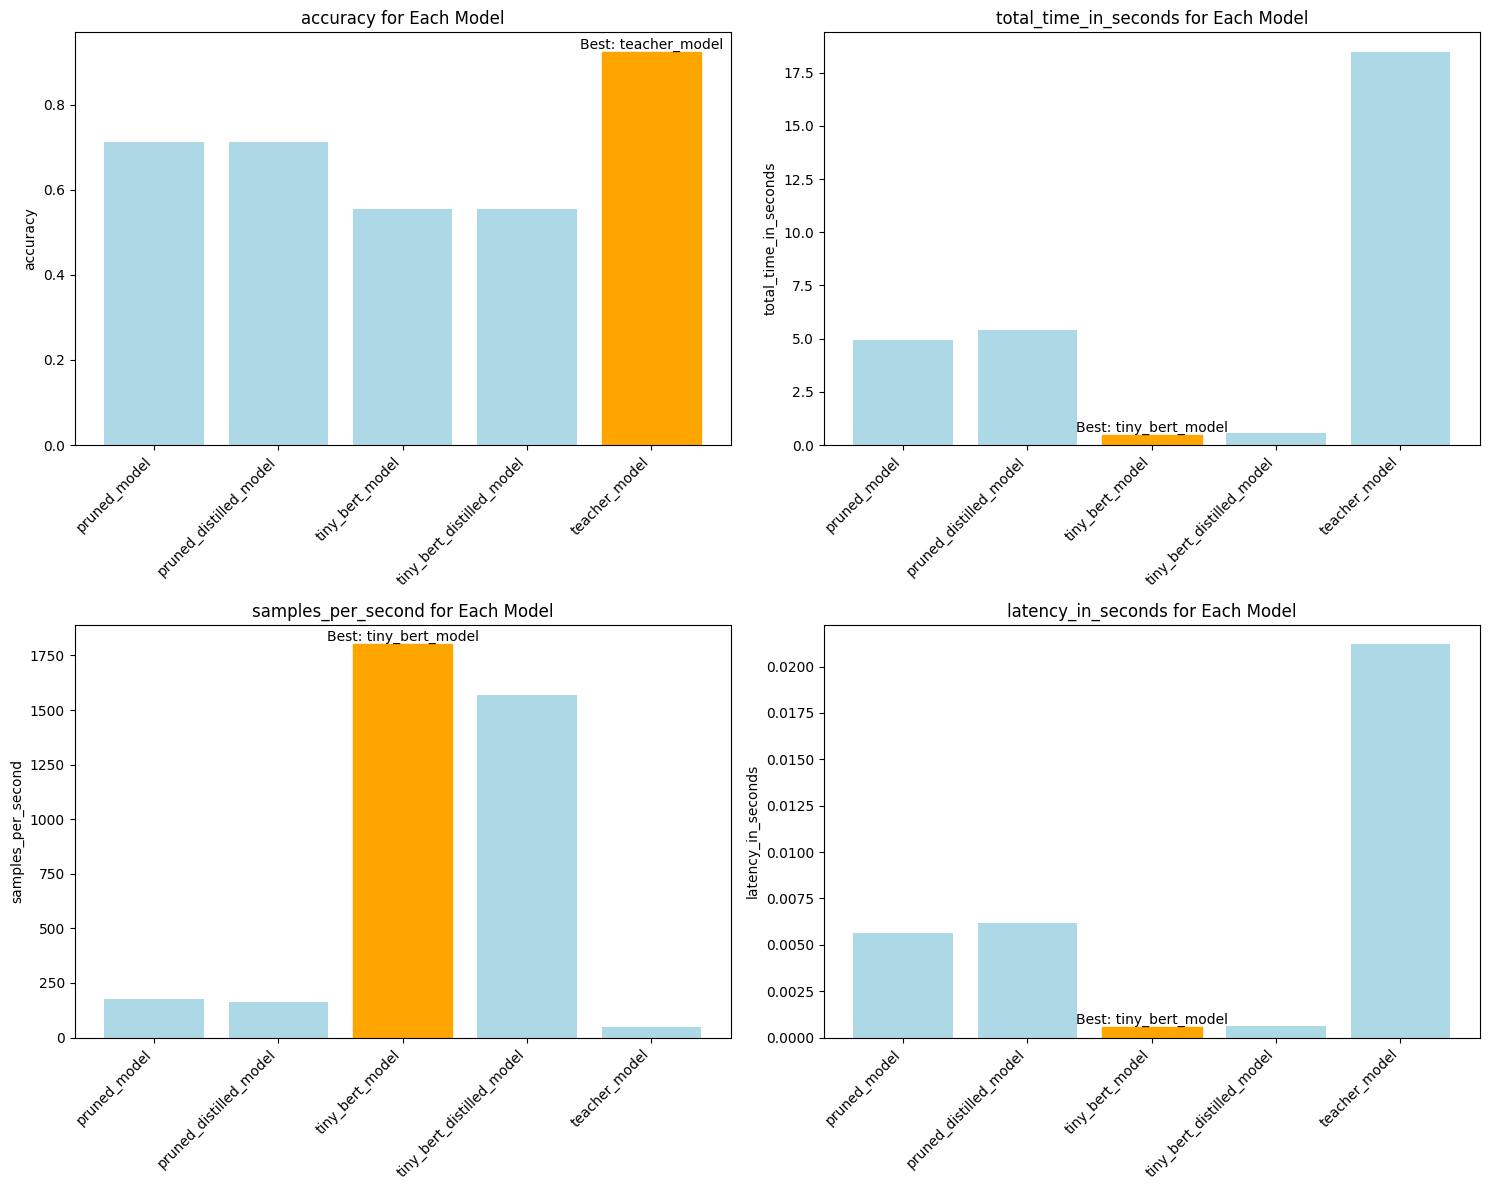

In [32]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np

#pruned_model_eval = {'accuracy': 0.9243119266055045, 'total_time_in_seconds': 15.120778457999677, 'samples_per_second': 57.66898856577498, 'latency_in_seconds': 0.01734034226834825}
#pruned_distilled_model_eval = {'accuracy': 0.91, 'total_time_in_seconds': 16.5, 'samples_per_second': 52.0, 'latency_in_seconds': 0.021}
#tiny_bert_model_eval = {'accuracy': 0.93, 'total_time_in_seconds': 18.0, 'samples_per_second': 49.5, 'latency_in_seconds': 0.02}
#tiny_bert_distilled_model_eval = {'accuracy': 0.91, 'total_time_in_seconds': 17.5, 'samples_per_second': 51.0, 'latency_in_seconds': 0.022}
#teacher_model_eval = {'accuracy': 0.94, 'total_time_in_seconds': 15.0, 'samples_per_second': 54.0, 'latency_in_seconds': 0.018}


model_results = {
    'pruned_model': pruned_model_eval,
    'pruned_distilled_model': pruned_distilled_model_eval,
    'tiny_bert_model': tiny_bert_model_eval,
    'tiny_bert_distilled_model': tiny_bert_distilled_model_eval,
    'teacher_model': teacher_model_eval
}

model_names = list(model_results.keys())
metrics = list(model_results[model_names[0]].keys())

# Create a plot for each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Loop over each metric and plot
for i, metric in enumerate(metrics):
    ax = axs[i // 2, i % 2]
    values = [model_results[model][metric] for model in model_names]
    best_value = max(values) if metric != 'total_time_in_seconds' and metric != 'latency_in_seconds' else min(values)
    best_model = model_names[values.index(best_value)]

    # Create a bar chart
    bars = ax.bar(model_names, values, color='lightblue')

    # Mark the best bar
    for bar in bars:
        if bar.get_height() == best_value:
            bar.set_color('orange')

    # Add labels and title
    ax.set_title(f'{metric} for Each Model')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(model_names))) # because of warning
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    
    # Highlight the best model with a label
    ax.text(best_model, best_value, f'Best: {best_model}', color='black', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


# Compare Performance on test prompts

In [33]:
# HTML, because I could'nt find a good package that has colspan functionality
from transformers import pipeline
import torch
from IPython.display import display, HTML

models = [
    {"model": pruned_model_trained, "tokenizer": tokenizer, "label": "Pruned"},
    {"model": pruned_distilled_model_trained, "tokenizer": tokenizer, "label": "Pruned + Distilled"},
    {"model": tiny_bert_model, "tokenizer": tokenizer, "label": "Tiny Bert"},
    {"model": tiny_bert_distilled_model, "tokenizer": tokenizer, "label": "Tiny Bert + Distilled"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Bert"}
    # Add more models as needed
]

# Initialize the classifier pipelines for each model
device = torch.device("cpu")

# Use 'pipeline' properly to initialize each model's text classification pipeline
pipelines = [
    pipeline("text-classification", model=model_info["model"], tokenizer=model_info["tokenizer"], device=-1)
    for model_info in models
]

# Assuming you have a list of prompts
prompts = [
    "This movie was amazing!",
    "I hated the ending.",
    "The acting was mediocre.",
    "It was an okay film.",
    "A truly captivating experience!"
]

# Create the HTML table structure for model results
model_results_html = '<table border="1" style="border-collapse: collapse;">'  # Table with borders collapsed

model_results_html += '<thead><tr><th  style="border: 1px solid black;background-color: #d3d3d3"></th>'  # First header cell

# Add headers for each model's label and score, with borders
for model in models:
    model_results_html += f'<th colspan="2" style="border: 1px solid black; text-align: center;background-color: #d3d3d3">{model["label"]}</th>'
model_results_html += '</tr><tr>'

model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Prompt</th>'  # Prompt header cell

# Add "Label" and "Score" headers for each model, with borders
for model in models:
    model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Label</th>'
    model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Score</th>'
model_results_html += '</tr></thead><tbody>'

# Process each prompt for all models and add to the HTML table
for prompt in prompts:
    model_results_html += f'<tr><td style="border: 1px solid black;">{prompt}</td>'  # Add borders for the Prompt cell
    
    for pipeline in pipelines:
        result = pipeline(prompt)[0]
        label = result['label']
        
        # Map the label to 1 (positive) or 0 (negative)
        if label == "positive":
            label = "1"  # Convert to string
        elif label == "negative":
            label = "0"  # Convert to string
        
        score = f"{result['score']:.4f}"
        model_results_html += f'<td style="border: 1px solid black;text-align: center">{label}</td>'  # Add borders for the Label column
        model_results_html += f'<td style="border: 1px solid black;text-align: center">{score}</td>'  # Add borders for the Score column
    
    model_results_html += '</tr>'

# Close the table tag
model_results_html += '</tbody></table>'

# Display the final HTML table with only model results
display(HTML(model_results_html))


Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


## Hyperparameter Search for Distillation parameter `alpha` & `temperature` with optuna

In [ ]:
#%pip install optuna

To do Hyperparameter Optimization using `optuna` we need to define our hyperparameter space. In this example we are trying to optimize/maximize the `num_train_epochs`, `learning_rate`, `alpha` & `temperature` for our `student_model`.

To start our Hyperparmeter search we just need to call `hyperparameter_search` provide our `hp_space` and number of trials to run.

In [ ]:
def hp_space(trial):
    return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 2),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3 ,log=True),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 30),
      }

In [ ]:
# Watch out for overwriting model again as before
# load local model here
def student_init():
    # Load pruned trained and untrained models
    pruned_model_trained_config = BertConfig.from_pretrained(f"{pruned_model_trained_path}/config.json")
    pruned_model_trained_config.hidden_size = 384
    pruned_model_trained_config.intermediate_size = 1536

    # Load model
    pruned_model_trained = AutoModelForSequenceClassification.from_pretrained(pruned_model_trained_path,
                                                                              config=pruned_model_trained_config,
                                                                              local_files_only=True,
                                                                              ignore_mismatched_sizes=True,
                                                                              device_map="cpu")
    return pruned_model_trained # needs to reload here
#    return AutoModelForSequenceClassification.from_pretrained(
#        student_id,
#        num_labels=num_labels,
#        id2label=id2label,
#        label2id=label2id
#    )

trainer = DistillationTrainer(
    model_init=student_init,
    args=training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"].select(range(1000)),
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator
)
best_run = trainer.hyperparameter_search(
    n_trials=2,
    direction="maximize",
    hp_space=hp_space
)

print(best_run)

Since optuna is just finding the best hyperparameters we need to fine-tune our model again using the best hyperparamters from the `best_run`.

In [ ]:
# overwrite initial hyperparameters with from the best_run
for k,v in best_run.hyperparameters.items():
    setattr(training_args, k, v)

# Define a new repository to store our distilled model
best_model_ckpt = "tiny-bert-best"
training_args.output_dir = best_model_ckpt

We have overwritten the default Hyperparameters with the one from our `best_run` and can start the training now.

In [ ]:
# Create a new Trainer with optimal parameters
optimal_trainer = DistillationTrainer(
    pruned_model_trained,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

optimal_trainer.train()


# save best model, metrics and create model card
trainer.create_model_card(model_name=training_args.hub_model_id)
trainer.push_to_hub()

In [ ]:
from huggingface_hub import HfApi

whoami = HfApi().whoami()
username = whoami['name']

print(f"https://huggingface.co/{username}/{repo_name}")

In [ ]:
print(pruned_model.config.id2label)


In [ ]:
from transformers import pipeline
import torch

# Assuming teacher_model and tokenizer are already loaded

# Initialize the classifier pipeline with CPU device
device = torch.device("cpu")
classifier = pipeline("text-classification", model=teacher_model, tokenizer=tokenizer, device=-1)  # -1 means CPU

# Ensure the model's id2label mapping is correct
teacher_model.config.id2label = {0: 'negative', 1: 'positive'}
teacher_model.config.label2id = {'negative': 0, 'positive': 1}

# Example prompts
prompts = [
    "This movie was amazing!",
    "I hated the ending.",
    "The acting was mediocre.",
    "It was an okay film.",
    "A truly captivating experience!"
]

# Process each prompt and print results
for prompt in prompts:
    # Run classification
    result = classifier(prompt)[0]  # Get the result for the first prompt
    
    # Check the output result
    print(f"Prompt: {prompt}")
    print(f"Raw Result: {result}")
    
    # Ensure the label is correctly mapped
    label = result['label']
    
    # Convert to the correct label if needed (this step may be redundant)
    if isinstance(label, str):  # If it's a string, print it directly
        print(f"Label: {label}, Score: {result['score']}\n")
    else:  # If it's an index, use id2label to convert
        label = teacher_model.config.id2label[label]
        print(f"Label: {label}, Score: {result['score']}\n")


In [ ]:
from transformers import pipeline
import torch
from rich.console import Console
from rich.table import Table

# Assuming teacher_model_a, teacher_model_b, tokenizer_a, tokenizer_b are already loaded

# List of models and tokenizers
models = [
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Pruned"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Pruned + Distilled"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Tiny Bert"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Tiny Bert + Distilled"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Bert"}
    # Add more models as needed
]
# Initialize the classifier pipelines for each model
device = torch.device("cpu")
pipelines = [
    pipeline("text-classification", model=model_info["model"], tokenizer=model_info["tokenizer"], device=-1)
    for model_info in models
]

# Create a Console object for rich output
console = Console()

# Create a Table object from rich with lines between rows
table = Table(show_header=True, header_style="bold magenta", show_edge=True, show_lines=True)

# Add the header for the table (Prompt column)
table.add_column("Prompt", justify="left", style="cyan", width=20)  # Wider width for the Prompt column

# Add merged header for each model's Label and Score columns
for model in models:
    table.add_column(f"{model['label']} Label", justify="left", style="green", width=15)  # Wider width for label
    table.add_column(f"{model['label']} Score", justify="left", style="yellow", width=15)  # Wider width for score

# Add the merged header row for the Label and Score under each model
header_row = ["Label", "Score"]
merged_header_row = []
for _ in models:
    merged_header_row.extend(header_row)  # Add "Label" and "Score" for each model, merging them under the model's name


# Process each prompt for all models and add to the table
for prompt in prompts:
    # First row: The prompt itself
    row_prompt = [prompt]
    
    # Second row: The results (labels and scores) for each model
    for pipeline in pipelines:
        result = pipeline(prompt)[0]
        label = result['label']
        
        # Map the label to 1 (positive) or 0 (negative)
        if label == "positive":
            label = "1"  # Convert to string
        elif label == "negative":
            label = "0"  # Convert to string
        
        score = f"{result['score']:.4f}"
        row_prompt.append(label)  # Add label (as string) for each model
        row_prompt.append(score)  # Add score for each model
    
    # Add the row to the table
    table.add_row(*row_prompt)

# Display the table
console.print(table)